<a href="https://colab.research.google.com/github/sambhe/CE6003/blob/master/Sarus_Demo_SD_DP_SQL_DP_Op_WL_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sarus Demo - Build and activate marketing segmentation with privacy guarantees

In this example, we use a public retail dataset, available on our github: https://github.com/sarus-tech/demo-notebooks

The objective is to build a market segmentation for the digital marketing team to activate. The data is sensitive as it contains confidential information about households. To segment the households data and push it to the activation tool without ever seeing it directly, we work with Sarus.

Read more in this blog post: https://www.sarus.tech/post/marketing-segmentation-strategy-without-data-access.

#0 - Setup and connection to the remote Sarus instance

In [1]:
%%capture
!pip install sarus==0.7.4 graphviz

In [2]:
%%capture
from IPython.display import display, HTML, Markdown, Latex, Code
from graphviz import Source
import matplotlib.pyplot as plt
import sarus

# Just adding "sarus." to the import lines (see supported libraries in the Sarus documentation)
import sarus.pandas as pd
from sarus.sklearn.cluster import KMeans

In [4]:
from sarus import Client
client = Client(url='https://try.sarus.tech/gateway', email='analyst@example.com') ## put your own credentials here

Password: ··········


#1. Exploring the tables of `retail_data`

## Listing the datasets

In [5]:
# The list of datasets is
datasets = client.list_datasets()
datasets

[<Sarus Dataset slugname=demo id=4>,
 <Sarus Dataset slugname=retail_data id=2>,
 <Sarus Dataset slugname=retail_data_public_products id=3>]

## Listing the tables in `retail_data`

In [6]:
# 'retail_data' is selected
remote_dataset = client.dataset(slugname='retail_data_public_products')
tables = remote_dataset.tables()

# One can comprehend the structure of data thanks to differentially private synthetic data
for path in tables:
  print('.'.join(path))
  table = remote_dataset.table(path).as_pandas()
  display(table.head())

retail_data_public_products.private.demographics_demo
Evaluated from synthetic data only


,household_id,age,income,home_ownership,marital_status,household_size,household_comp,kids_count
0,1,65+,35-49K,,Unmarried,1,1 Adult No Kids,0
1,2,35-44,35-49K,Homeowner,Married,2,2 Adults No Kids,0
2,3,55-64,25-34K,,Unmarried,1,1 Adult No Kids,0
3,4,45-54,50-74K,,Married,2,1 Adult Kids,1
4,5,25-34,50-74K,Homeowner,Unmarried,1,1 Adult No Kids,0


retail_data_public_products.private.products_demo


,product_id,manufacturer_id,department,brand,product_category,product_type,package_size
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISCELLANEOUS,National,,,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ


retail_data_public_products.private.transactions_demo
Evaluated from synthetic data only


,household_id,store_id,basket_id,product_id,quantity,sales_value,retail_disc,coupon_disc,coupon_match_disc,week,transaction_timestamp
0,1,422,3.162493e+10,834167,0.999998,2.526734,0.552784,0.0,0.0,8,2017-01-02 18 00:27
1,1,339,3.162626e+10,834167,1.000001,2.938805,1.403942,0.0,0.0,5,2017-02-01-25:41:21
2,1,321,3.166877e+10,834167,0.999996,1.995808,0.897342,0.0,0.0,6,20:07 18:30 19:51:5
3,1,333,3.153261e+10,834167,0.999996,1.615014,1.336103,0.0,0.0,8,2017-017-02-017-04
4,1,367,3.135975e+10,834167,1.000000,3.529065,0.000000,0.0,0.0,2,2017-07 13:55:25 23


#2. Running private SQL queries

## A first simple DP query

In [7]:
# Run a simple SQL query
query = """
SELECT
  avg(sales_value)
FROM
  retail_data_public_products.private.transactions_demo
"""
display(Code(query, language='sql'))
avg_value = remote_dataset.sql(query).as_pandas()
avg_value

SELECT
  avg(sales_value)
FROM
  retail_data_public_products.private.transactions_demo

Differentially-private evaluation (epsilon=1.99)


,avg_sales_value
0,3.099345


## A query falling back to DP synthetic data


In [8]:
# Synthetic data suggest the following query
query = """
SELECT
  substring(transaction_timestamp, 1, 4) AS y,
  substring(transaction_timestamp, 6, 2) AS m,
  substring(transaction_timestamp, 9, 2) AS d,
  sales_value
FROM retail_data_public_products.private.transactions_demo
"""
display(Code(query, language='sql'))
year_month_value = remote_dataset.sql(query).as_pandas()
year_month_value

SELECT
  substring(transaction_timestamp, 1, 4) AS y,
  substring(transaction_timestamp, 6, 2) AS m,
  substring(transaction_timestamp, 9, 2) AS d,
  sales_value
FROM retail_data_public_products.private.transactions_demo

Evaluated from synthetic data only


,y,m,d,sales_value
0,2017,01,02,2.526734
1,2017,02,01,2.938805
2,20:0,1,:3,1.995808
3,2017,01,-0,1.615014
4,2017,07,13,3.529065
...,...,...,...,...
100000,201-,1,5,4.215796
100001,2017,02,10,4.031145
100002,201-,8:,9:,1.943565
100003,2017,01,-0,1.273484


## A DP query with `GROUP BY`

SELECT
  substring(transaction_timestamp, 6, 2) AS "month",
  sum(sales_value) AS monthly_value
FROM retail_data_public_products.private.transactions_demo
GROUP BY substring(transaction_timestamp, 6, 2)

Differentially-private evaluation (epsilon=1.82)


<BarContainer object of 2 artists>

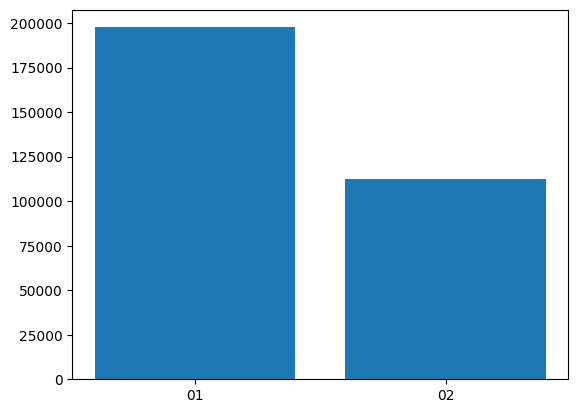

In [9]:
# Run a simple SQL query
query = """
SELECT
  substring(transaction_timestamp, 6, 2) AS "month",
  sum(sales_value) AS monthly_value
FROM retail_data_public_products.private.transactions_demo
GROUP BY substring(transaction_timestamp, 6, 2)
"""
display(Code(query, language='sql'))
df = remote_dataset.sql(query).as_pandas()
df = sarus.eval(df, target_epsilon=2.0)
plt.bar(df.month, df.monthly_value)

#3. Running private `sarus.panda` methods on a data extract

## Select the most valuable transactions


In [10]:
# Synthetic data suggest the following query
query = """
SELECT
    *
FROM
    retail_data_public_products.private.transactions_demo
WHERE
    sales_value > 3
"""
display(Code(query, language='sql'))
ds = remote_dataset.sql(query).as_pandas()
ds.head()

SELECT
    *
FROM
    retail_data_public_products.private.transactions_demo
WHERE
    sales_value > 3

Evaluated from synthetic data only


,household_id,store_id,basket_id,product_id,quantity,sales_value,retail_disc,coupon_disc,coupon_match_disc,week,transaction_timestamp
0,1,367,3.135975e+10,834167,1.000000,3.529065,0.00000,0.0,0.0,2,2017-07 13:55:25 23
1,1,309,3.143676e+10,834167,1.000000,5.496607,1.26804,0.0,0.0,4,2017-02-09:10 23 22
2,1,315,3.135938e+10,834167,0.999995,4.357350,0.00000,0.0,0.0,3,201-017-02:29 22:13
3,1,448,3.179872e+10,834167,0.999996,7.489274,0.85354,0.0,0.0,7,201-29:04 22:13 02-
4,1,375,3.134225e+10,834167,0.999997,21.882557,0.00000,0.0,0.0,2,20:13:05:57:04 017-


## Compute some statistics with pandas

In [11]:
# The size of the dataset
ds.shape

Differentially-private evaluation (epsilon=1.83)


(29345, 11)

In [12]:
# The size of the dataset
sarus.eval(ds.shape, target_epsilon=0.1)

Differentially-private evaluation (epsilon=0.09)


(29320, 11)

In [ ]:
# The average transaction can be computed with DP
ds.sales_value.mean()

In [14]:
# The dataset can be further filtered
ds[ds.sales_value>10].shape

Differentially-private evaluation (epsilon=1.83)


(2948, 11)

Differentially-private evaluation (epsilon=1.83)
Differentially-private evaluation (epsilon=0.01)


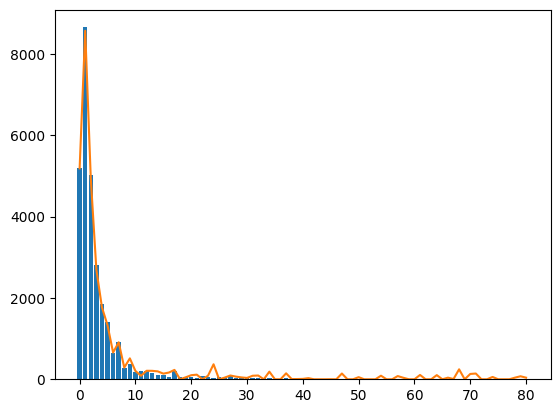

In [15]:
# Display the value distribution
value_distrib = ds.sales_value.round().value_counts()
freqs = sarus.eval(value_distrib, target_epsilon=2).sort_index()
plt.bar(range(len(freqs)), freqs)

freqs = sarus.eval(value_distrib, target_epsilon=0.01).sort_index()
plt.plot(range(len(freqs)), freqs, color='tab:orange')

#4. Leveraging `sarus.sklearn` to train a clustering ML model


In [16]:
# Extracting the interesting part of the datasets via a SQL query.
query = """
SELECT
    *
FROM
    retail_data_public_products.private.demographics_demo demo_
    JOIN retail_data_public_products.private.transactions_demo transact_
    ON demo_.household_id = transact_.household_id
    JOIN retail_data_public_products.private.products_demo products_
    ON transact_.product_id = products_.product_id
"""
display(Code(query, language='sql'))
df = remote_dataset.sql(query).as_pandas()
df.head()

SELECT
    *
FROM
    retail_data_public_products.private.demographics_demo demo_
    JOIN retail_data_public_products.private.transactions_demo transact_
    ON demo_.household_id = transact_.household_id
    JOIN retail_data_public_products.private.products_demo products_
    ON transact_.product_id = products_.product_id

Evaluated from synthetic data only


,demo_household_id,age,income,home_ownership,marital_status,household_size,household_comp,kids_count,transact_household_id,store_id,...,coupon_match_disc,week,transaction_timestamp,products_product_id,manufacturer_id,department,brand,product_category,product_type,package_size
0,1,65+,35-49K,,Unmarried,1,1 Adult No Kids,0,1,422,...,0.0,8,2017-01-02 18 00:27,834167,2345,GROCERY,National,DOMESTIC WINE,PREMIUM 750ML WINES,750 ML
1,1,65+,35-49K,,Unmarried,1,1 Adult No Kids,0,1,339,...,0.0,5,2017-02-01-25:41:21,834167,2345,GROCERY,National,DOMESTIC WINE,PREMIUM 750ML WINES,750 ML
2,1,65+,35-49K,,Unmarried,1,1 Adult No Kids,0,1,321,...,0.0,6,20:07 18:30 19:51:5,834167,2345,GROCERY,National,DOMESTIC WINE,PREMIUM 750ML WINES,750 ML
3,1,65+,35-49K,,Unmarried,1,1 Adult No Kids,0,1,333,...,0.0,8,2017-017-02-017-04,834167,2345,GROCERY,National,DOMESTIC WINE,PREMIUM 750ML WINES,750 ML
4,1,65+,35-49K,,Unmarried,1,1 Adult No Kids,0,1,367,...,0.0,2,2017-07 13:55:25 23,834167,2345,GROCERY,National,DOMESTIC WINE,PREMIUM 750ML WINES,750 ML


## Preprocessing the data

In [17]:
# Cleaning the data
df_dem = df[['demo_household_id', 'home_ownership', 'age', 'income', 'marital_status', 'household_size', 'household_comp', 'kids_count']]
df_dem = df_dem.drop_duplicates()

# Encoding categorial variables
cat = pd.get_dummies(df_dem.select_dtypes(["object"]), drop_first=True)
cat = pd.concat([df_dem['demo_household_id'], cat], axis=1)
print("cat")
display(cat.head())

# Adding the cosmetics consumption column
cosmetics_consumption = df.loc[df['department'] == 'COSMETICS'].groupby('demo_household_id').agg({'department' : 'count'}).rename(columns = {'department' : 'count_cosmetics_consumption'})
print("cosmetics_consumption")
display(cosmetics_consumption.head())

# Putting all together
df_full = pd.merge(cat, cosmetics_consumption, how='left', on=['demo_household_id']).fillna(0)
print("df_full")
display(df_full.head())

cat
Evaluated from synthetic data only


,demo_household_id,home_ownership_Homeowner,home_ownership_Probable Homeowner,home_ownership_Probable Renter,home_ownership_Renter,age_25-34,age_35-44,age_45-54,age_55-64,age_65+,...,household_size_2,household_size_3,household_size_4,household_size_5+,household_comp_1 Adult No Kids,household_comp_2 Adults Kids,household_comp_2 Adults No Kids,kids_count_1,kids_count_2,kids_count_3+
0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
127,2,1,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,1,0,0,0
189,3,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
204,4,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0
211,5,1,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


cosmetics_consumption
Evaluated from synthetic data only


,count_cosmetics_consumption
demo_household_id,
6,17
8,33
17,96
18,3
19,21


df_full
Evaluated from synthetic data only


,demo_household_id,home_ownership_Homeowner,home_ownership_Probable Homeowner,home_ownership_Probable Renter,home_ownership_Renter,age_25-34,age_35-44,age_45-54,age_55-64,age_65+,...,household_size_3,household_size_4,household_size_5+,household_comp_1 Adult No Kids,household_comp_2 Adults Kids,household_comp_2 Adults No Kids,kids_count_1,kids_count_2,kids_count_3+,count_cosmetics_consumption
0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0.0
1,2,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0.0
2,3,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0.0
3,4,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0.0
4,5,1,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0.0


## Fitting a model

In [18]:
# Fitting a sklearn clustering model
model = KMeans(n_clusters=2)
fitted_model = model.fit(df_full)

# Checking the model; it is "Whitelisted": it means the Data owner has exceptionally granted me the right to fit the model on the real remote data directly with Differential Privacy
fitted_model

Whitelisted


KMeans(n_clusters=2, n_init=10)

### Under the hood
Below is the graph that is compiled by the Sarus SDK to analyze the requested sequence of operations, see if the analyst is autorized to run it on the remote data and compile an authorized alternative if not.

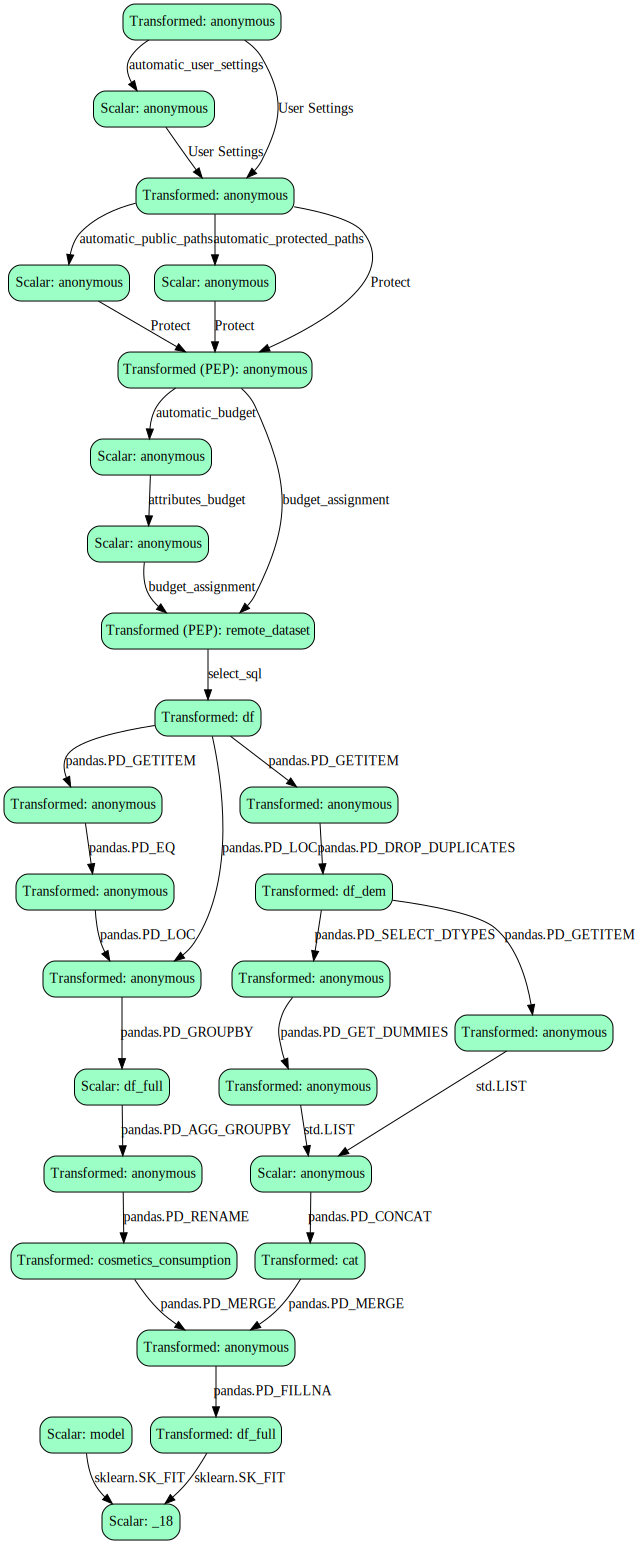

In [19]:
from graphviz import Source

Source(fitted_model.dot("user_defined"))

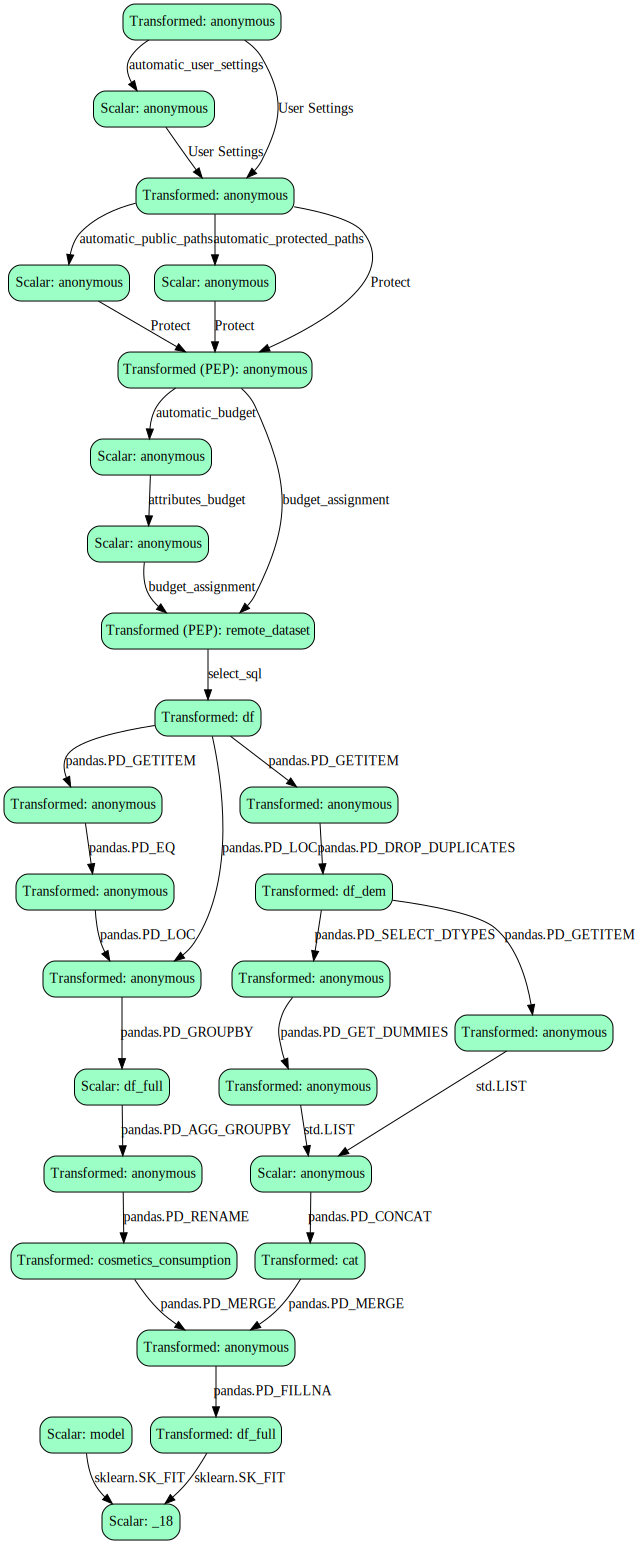

In [20]:
Source(fitted_model.dot("alternative"))

#3. Pushing the resulting ids to an endpoint for activation in a marketing tool



In [21]:
labels = fitted_model.predict(df_full)
new_df = pd.concat([df_dem.reset_index()['demo_household_id'], pd.DataFrame(labels, columns=['group'])], axis=1)

In [22]:
new_df.head()

Evaluated from synthetic data only


,demo_household_id,group
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1


In [23]:
### Creating the two lists of ids

list_ids_1 = new_df.loc[new_df.group == 0]['demo_household_id']
list_ids_2 = new_df.loc[new_df.group == 1 ]['demo_household_id']

In [24]:
list_ids_1.shape

Evaluated from synthetic data only


(399,)

In [ ]:
### Pushing the first segmentat of ids to the endpoint for activation in the marketing campaign solution

# sarus.push(list_ids_1, endpoint="https://my_marketing_solution/activate", name='cosmetics_audience_1') # NB: BETA VERSION. NB2: the server is implemented outside of Sarus

In [ ]:
### Pushing the first segmentat of ids to the endpoint for activation in the marketing campaign solution

# sarus.push(list_ids_2, endpoint="https://my_marketing_solution/activate", name='cosmetics_audience_2') # NB: BETA VERSION. NB2: the server is implemented outside of Sarus

#5. Conclusion

We could build a market segmentation using usual python libraries, without ever seeing the real households data, and push the insights to a third-party tool for the digital marketing team to use them! The data were fully protected and we were able to unlock all its significant value.

Want to schedule a test and see Sarus in action on your data? [Get in touch!](https://www.sarus.tech/contact)